<a href="https://colab.research.google.com/github/DouglasDFisher/DougFisher/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)       

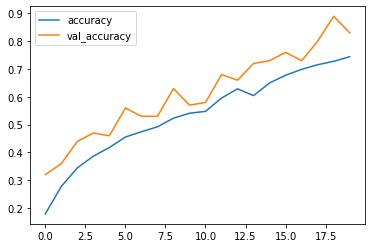

In [2]:
!pip install -q tensorflow-io
!pip install pydub
!pip install pathlib2

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.io import FixedLenFeature, parse_single_example
from librosa.core.time_frequency import mel_frequencies
from pathlib2 import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

test_type = 1; # 1 - Genre, 2 - Instrument

if test_type == 1:
  dataset = tfds.load('gtzan', split="train", shuffle_files=True)

  dataset = dataset.map(
      lambda data: (tf.expand_dims(tfio.experimental.audio.spectrogram(
      tf.cast(tf.slice(data["audio"], [0,], [660000,]), tf.float64),
      nfft=1024, window=512, stride=512), -1), data['label']))
  
elif test_type == 2:
  DATA_DIR = Path("data").resolve()
  DATA_DIR

  dataset, ds_test = tfds.load(
      name="nsynth/gansynth_subset", split=["train", "test"], data_dir=DATA_DIR
  )

  dataset = dataset.map(
     lambda data: (tf.expand_dims(tfio.experimental.audio.spectrogram(data["audio"],
     nfft=1024, window=512, stride=512), -1), data["instrument"]["label"]))

norm = preprocessing.Normalization()
norm.adapt(dataset.map(lambda x, _: x))
model = keras.Sequential([
    layers.Input(shape=iter(dataset).get_next()[0].shape),
    preprocessing.Resizing(32, 32),
    norm,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

if test_type == 1:
  batch_size = 8;
elif test_type == 2:
  batch_size = 64;

history = model.fit(
    dataset.skip(100).batch(batch_size),
    validation_data=dataset.take(100).batch(8),
    epochs=20,
    
)

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()